# Análise exploratória de instrumentos de medição

In [10]:
!pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable


In [3]:
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder
    .master("local")
    .appName("Análise de instrumentos")
    .config('spark.ui.port', '4050')
    .getOrCreate()
)

In [42]:
path = './tabela_instrumentos.csv'
instrumentos = spark.read.csv(path, inferSchema=True, header=True)
instrumentos = instrumentos.na.fill(value="", subset=["entregue_em"])
instrumentos.toPandas()

,instrumentos_do_lote,quantidade_instrumentos,status_atual,data_prazo,entregue_em
0,Rugosímetro,5,Atrasado,13/11/2023,16/11/2023
1,Luxímetros digitais,21,Entregue,14/11/2023,14/11/2023
2,Paquímetro universal,30,Atrasado,14/11/2023,18/11/2023
3,Rugosímetro,2,Entregue antes,16/11/2023,15/11/2023
4,Termo-higrômetros,100,Atrasado,17/11/2023,20/11/2023
5,Paquimetros digitais,41,Atrasado,17/11/2023,24/11/2023
6,Paquimetros digitais,32,Atrasado,20/11/2023,22/11/2023
7,Micrômetros,6,Entregue,21/11/2023,21/11/2023
8,Termo-higrômetros,20,Entregue,22/11/2023,22/11/2023
9,Paquímetro universal,10,Não entregue,23/11/2023,


In [43]:

instrumentos.describe()

DataFrame[summary: string, instrumentos_do_lote: string, quantidade_instrumentos: string, status_atual: string, data_prazo: string, entregue_em: string]

In [44]:
instrumentos.printSchema()

root
 |-- instrumentos_do_lote: string (nullable = true)
 |-- quantidade_instrumentos: integer (nullable = true)
 |-- status_atual: string (nullable = true)
 |-- data_prazo: string (nullable = true)
 |-- entregue_em: string (nullable = false)



In [45]:
instrumentos.summary().show()

+-------+--------------------+-----------------------+------------+----------+-----------+
|summary|instrumentos_do_lote|quantidade_instrumentos|status_atual|data_prazo|entregue_em|
+-------+--------------------+-----------------------+------------+----------+-----------+
|  count|                  10|                     10|          10|        10|         10|
|   mean|                NULL|                   26.7|        NULL|      NULL|       NULL|
| stddev|                NULL|     28.833044314543766|        NULL|      NULL|       NULL|
|    min| Luxímetros digitais|                      2|    Atrasado|13/11/2023|           |
|    25%|                NULL|                      6|        NULL|      NULL|       NULL|
|    50%|                NULL|                     20|        NULL|      NULL|       NULL|
|    75%|                NULL|                     32|        NULL|      NULL|       NULL|
|    max|   Termo-higrômetros|                    100|Não entregue|23/11/2023| 24/11/2023|

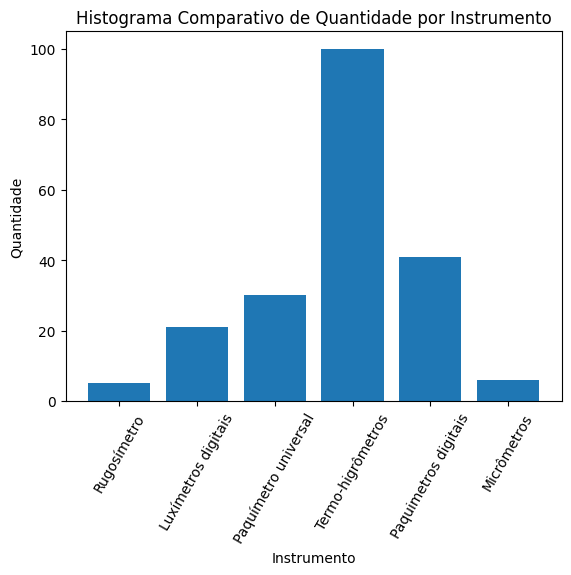

In [49]:
from matplotlib import pyplot as plt
plt.bar(instrumentos.toPandas()["instrumentos_do_lote"], instrumentos.toPandas()["quantidade_instrumentos"])
plt.title('Histograma Comparativo de Quantidade por Instrumento')
plt.xlabel('Instrumento')
plt.ylabel('Quantidade')
# Rotacione as labels do eixo x
plt.xticks(rotation=60)
plt.show()

# Construção do KPI a partir da porcentagem de instrumentos entregues no prazo

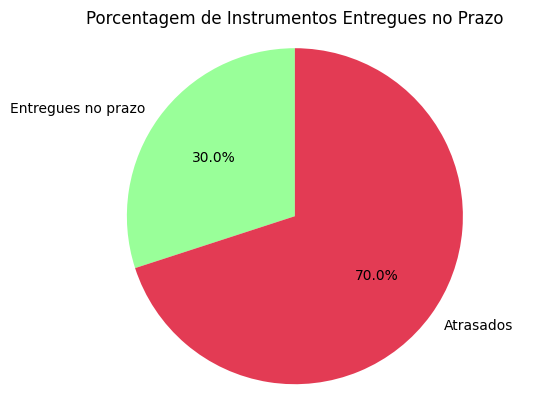

In [57]:
total_instrumentos = instrumentos.count()
entregues_no_prazo = instrumentos.filter("status_atual = 'Entregue' AND entregue_em = data_prazo").count()
porcentagem_entregues_no_prazo = (entregues_no_prazo / total_instrumentos) * 100

# Crie um gráfico de pizza para visualizar o KPI
labels = ['Entregues no prazo', 'Atrasados']
sizes = [porcentagem_entregues_no_prazo, 100 - porcentagem_entregues_no_prazo]
colors = ['#99ff99','#e33b54']

plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
plt.title('Porcentagem de Instrumentos Entregues no Prazo')
plt.axis('equal')  # Equal aspect ratio garante que o gráfico de pizza seja circular.
plt.show()

# KPI de Produtividade - Total de produtos entregues por dia

In [53]:
from pyspark.sql.functions import col, to_date
from pyspark.sql import functions as F

# Convertemos a coluna de data para o formato Date
instrumentos = instrumentos.withColumn("data_prazo", to_date(col("data_prazo"), "dd/MM/yyyy"))
instrumentos = instrumentos.withColumn("entregue_em", to_date(col("entregue_em"), "dd/MM/yyyy"))

# Calcula a quantidade total de instrumentos entregues
total_entregues = instrumentos.filter("status_atual = 'Entregue'").agg(F.sum("quantidade_instrumentos")).collect()[0][0]

# Calcula o número total de dias
data_inicial = instrumentos.select(F.min("data_prazo")).collect()[0][0]
data_final = instrumentos.select(F.max("entregue_em")).collect()[0][0]
total_dias = (data_final - data_inicial).days + 1  # Adiciona 1 para incluir o dia final

# Calcula a produtividade por dia
produtividade_por_dia = total_entregues / total_dias
print(f"Total de Instrumentos Entregues: {total_entregues}")
print(f"Total de Dias: {total_dias}")
print(f"Produtividade por Dia: {produtividade_por_dia:.2f} instrumentos/dia")

Total de Instrumentos Entregues: 47
Total de Dias: 12
Produtividade por Dia: 3.92 instrumentos/dia
